Importando bibliotecas

In [45]:
import numpy as np
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split

Carregando o dataset

In [46]:
df = pd.read_csv('casas.csv')
print(df.head())

   Area_m2  Num_Quartos  Num_Banheiros  Idade_Casa_Anos Localizacao Garagem  \
0      120            3              2                5           A     Sim   
1       85            2              1               10           B     Nao   
2      200            4              3                2           A     Sim   
3      150            3              2                8           C     Sim   
4       95            2              2               15           B     Sim   

   Preco_Venda  
0       350000  
1       220000  
2       550000  
3       400000  
4       280000  


Melhoria 1: Tratamento de Dados Categóricos (Feature Encoding)

In [47]:
onehot = pd.get_dummies(df, columns=['Garagem'],dtype=int)
onehot = pd.get_dummies(onehot, columns=['Localizacao'],dtype=int)


Melhoria 2: Normalização/Padronização dos Dados Numéricos

In [48]:

def prorcurando_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[coluna][(df[coluna] < lower_bound) & (df[coluna] > upper_bound)]

    print(f"\nOutliers na coluna {coluna} (IQR):\n", outliers)




In [49]:
prorcurando_outliers(onehot,'Area_m2')
prorcurando_outliers(onehot,'Preco_Venda')
prorcurando_outliers(onehot,'Idade_Casa_Anos')


Outliers na coluna Area_m2 (IQR):
 Series([], Name: Area_m2, dtype: int64)

Outliers na coluna Preco_Venda (IQR):
 Series([], Name: Preco_Venda, dtype: int64)

Outliers na coluna Idade_Casa_Anos (IQR):
 Series([], Name: Idade_Casa_Anos, dtype: int64)


Demonstrando

In [50]:
def grafico_box_plot(df, coluna):
    plt.figure(figsize=(8, 6))

    # Criar o Box Plot
    # patch_artist=True preenche as caixas com cor
    # vert=False cria um box plot horizontal
    plt.boxplot(df[coluna], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='blue', linestyle='--'),
                capprops=dict(color='green'))

    plt.title(f'Box Plot para Identificação de Outliers na coluna {coluna}')
    plt.ylabel('Valores')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()
    plt.clf()

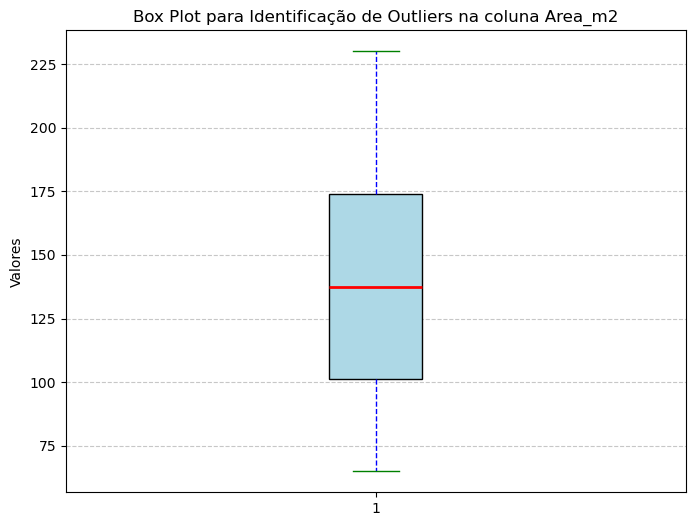

<Figure size 640x480 with 0 Axes>

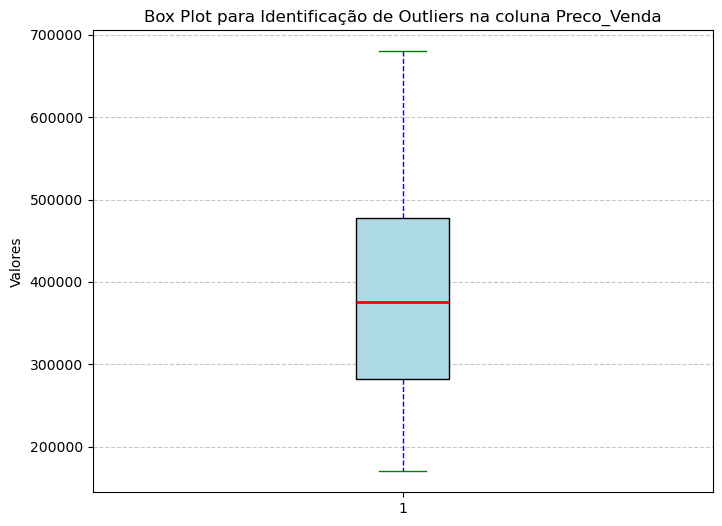

<Figure size 640x480 with 0 Axes>

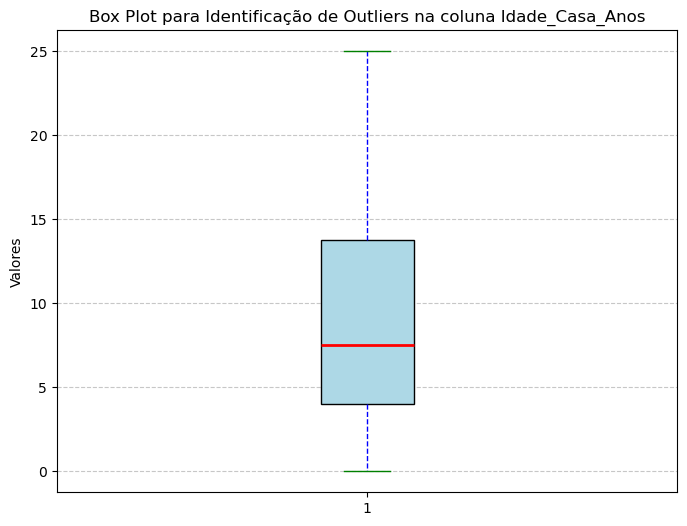

<Figure size 640x480 with 0 Axes>

In [51]:
grafico_box_plot(onehot,'Area_m2')
grafico_box_plot(onehot,'Preco_Venda')
grafico_box_plot(onehot,'Idade_Casa_Anos')

In [52]:
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()
def normalizandoX(df,coluna):
    df[coluna] = scalerX.fit_transform(df[[coluna]])
def normalizandoY(df,coluna):
    df[coluna] = scalerY.fit_transform(df[[coluna]])


In [53]:
normalizandoX(onehot,'Area_m2')
normalizandoX(onehot,'Num_Quartos')
normalizandoX(onehot,'Num_Banheiros')
normalizandoX(onehot,'Idade_Casa_Anos')
normalizandoY(onehot,'Preco_Venda')

onehot.to_csv('corrigido.csv', index = False)

Melhoria 3: Seleção de Características (Feature Selection)

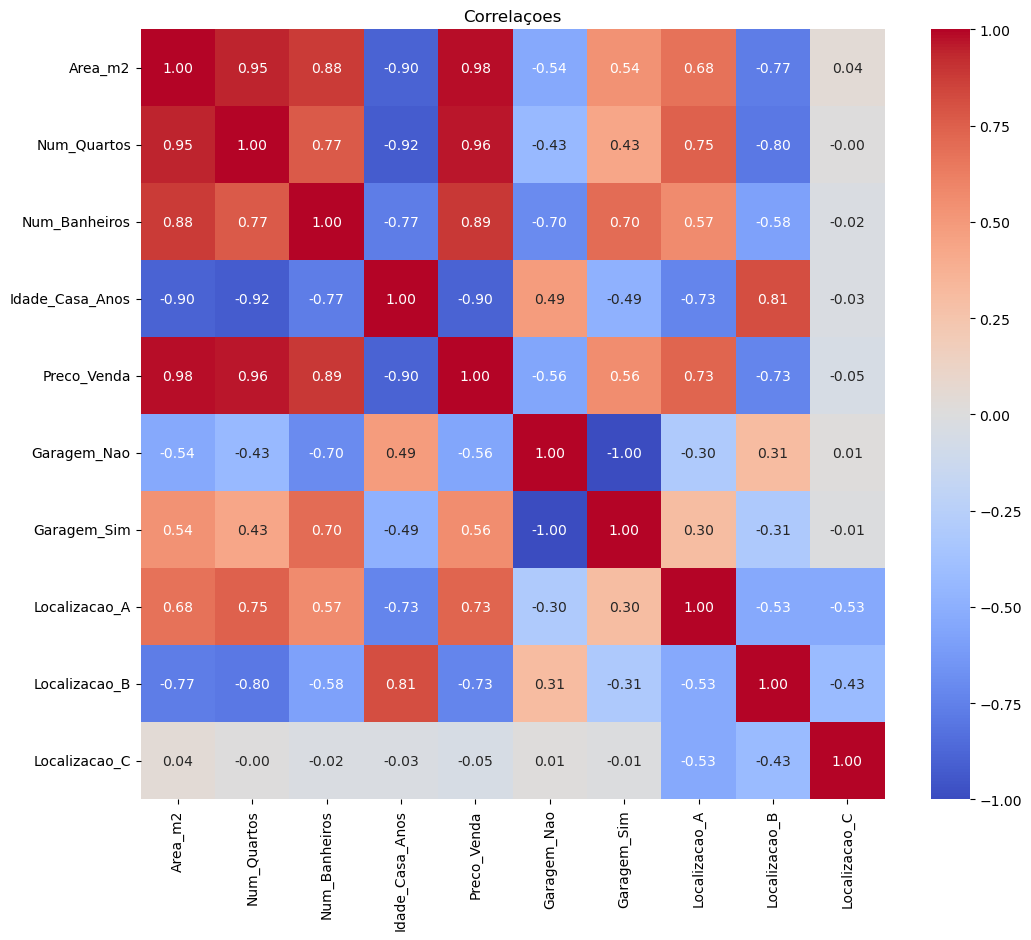

<Figure size 640x480 with 0 Axes>

In [54]:
onehot.corr()
plt.figure(figsize=(12,10))
sns.heatmap(onehot.corr(),annot = True, cmap = 'coolwarm',fmt='.2f')
plt.title('Correlaçoes')
plt.show()
plt.clf()

Número de quartos, número de banheiros, área e idade da casa são os mais relevantes para o nosso targe, por propósitos de "Melhoria 4: Engenharia de Características (Feature Engineering)" unirei as duas features

In [55]:
nova_coluna = df['Num_Quartos'] + df['Num_Banheiros']
onehot['Total_Comodos'] = nova_coluna

normalizandoX(onehot,'Total_Comodos')
onehot.drop(columns=['Num_Quartos','Num_Banheiros'], inplace=True)
onehot.to_csv('corrigido_com_coluna_nova.csv')

Demonstrando relações de novo

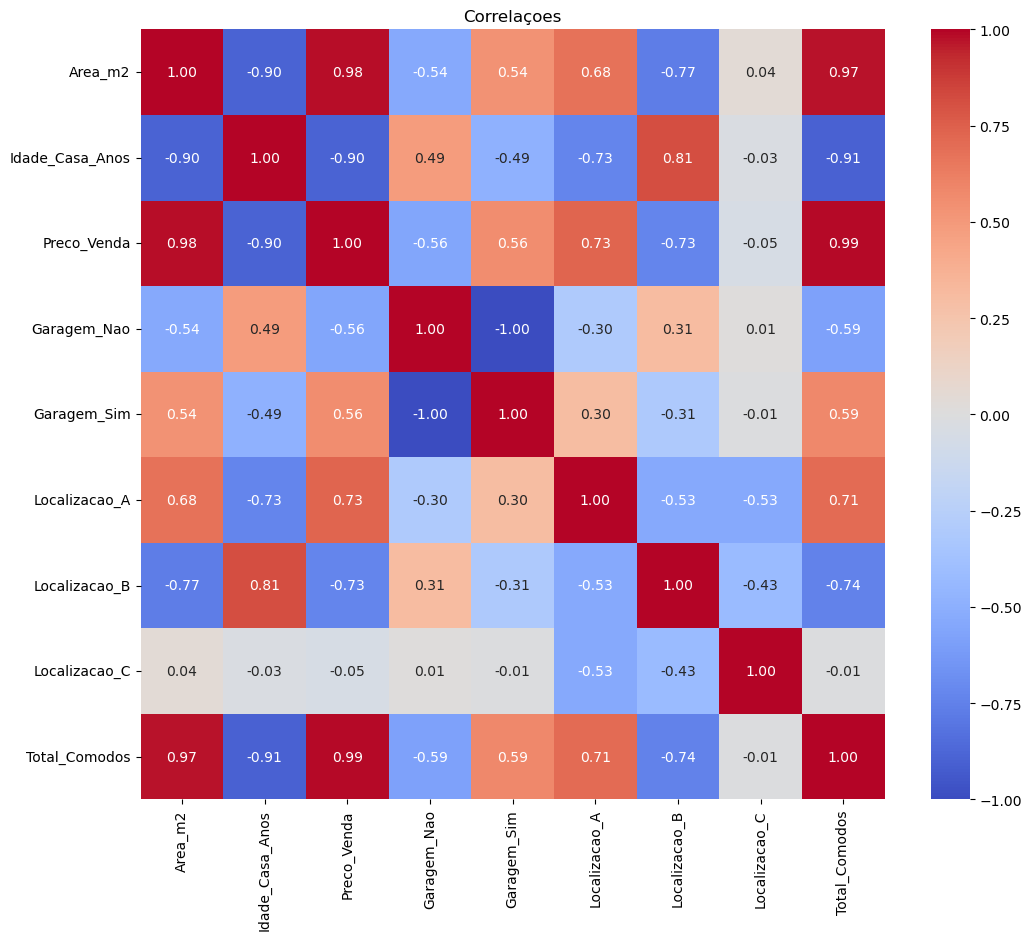

<Figure size 640x480 with 0 Axes>

In [56]:
onehot.corr()
plt.figure(figsize=(12,10))
sns.heatmap(onehot.corr(),annot = True, cmap = 'coolwarm',fmt='.2f')
plt.title('Correlaçoes')
plt.show()
plt.clf()

Dividindo os dados em treino e teste

In [57]:
X = onehot[['Area_m2','Idade_Casa_Anos', 'Total_Comodos']]
y = onehot[['Preco_Venda']]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Modelo RNA

In [58]:
model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=(x_train.shape[1],)),
    layers.Dense(1)
])



/opt/anaconda3/envs/processamentoevisu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilando, adam é um bom optimizador para regressao, e mean_squared_error é uma boa função de erro, também para regressão

In [59]:
model.compile(
    optimizer = 'adam',
    loss='mean_squared_error', 
              metrics=['mse'])


Treinamento (salvando os erros)

In [60]:
loss = model.fit(x_train,y_train, epochs = 1000, verbose =1)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.1469 - mse: 0.1469
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1454 - mse: 0.1454
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1439 - mse: 0.1439
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1424 - mse: 0.1424
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1409 - mse: 0.1409
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1394 - mse: 0.1394
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1379 - mse: 0.1379
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1365 - mse: 0.1365
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1350 - mse: 0.1350
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1335 - mse: 0.1335
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1321 - mse: 0.1321
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1307 - mse: 0.1307
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━

Testei com 100 epocas, porem o MSE ficou em 0.44, ajustando para 1000 tivemos um valor muito mais baixo, de 0.000795

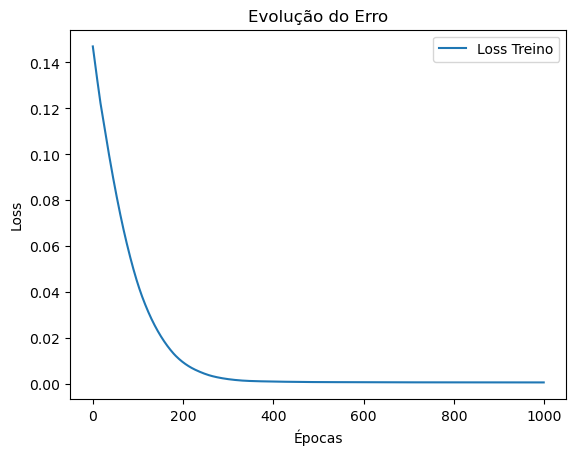

In [61]:
plt.plot(loss.history['loss'], label='Loss Treino')
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Evolução do Erro')
plt.show()

Predizendo valores

In [65]:
y_pred = model.predict(x_test)
y_pred_real = scalerY.inverse_transform(y_pred)
x_test_real = scalerX.inverse_transform(x_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


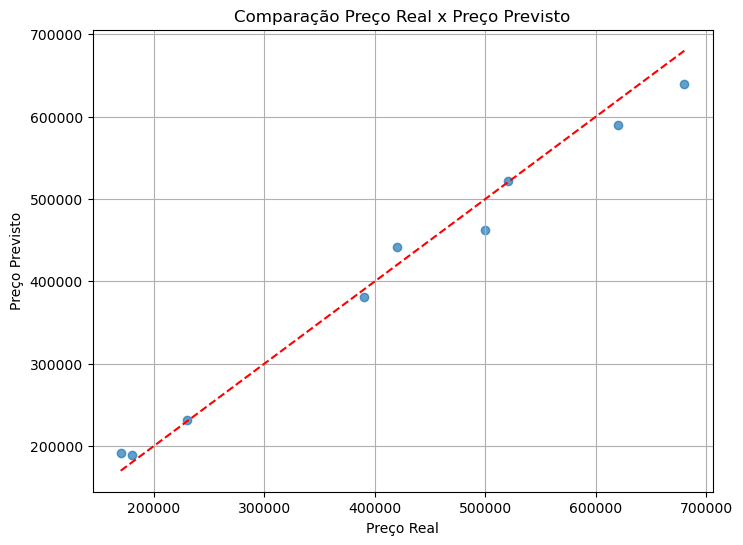

In [68]:
y_test_real = scalerY.inverse_transform(y_test)
plt.figure(figsize=(8,6))
plt.scatter(y_test_real, y_pred_real, alpha=0.7)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')  # Linha y=x

plt.xlabel('Preço Real')
plt.ylabel('Preço Previsto')
plt.title('Comparação Preço Real x Preço Previsto')
plt.grid(True)
plt.show()